In [5]:
import functools
import json
import os
from typing import Any, List, Tuple, Union
import matplotlib.pyplot as plt
import torch
import torch as t
import torch.nn.functional as F
from fancy_einsum import einsum
from sklearn.linear_model import LinearRegression
from torch import nn
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from einops import rearrange, repeat
import pandas as pd
import numpy as np

import w5d5_tests
from w5d5_transformer import ParenTransformer, SimpleTokenizer

MAIN = __name__ == "__main__"
DEVICE = t.device("cpu")
IS_CI = os.environ.get("CI", False)

In [6]:
if MAIN:
    model = ParenTransformer(ntoken=5, nclasses=2, d_model=56, nhead=2, d_hid=56, nlayers=3).to(DEVICE)
    state_dict = t.load("w5d5_balanced_brackets_state_dict.pt")
    model.to(DEVICE)
    model.load_simple_transformer_state_dict(state_dict)
    model.eval()
    tokenizer = SimpleTokenizer("()")
    with open("w5d5_brackets_data.json") as f:
        data_tuples: List[Tuple[str, bool]] = json.load(f)
        print(f"loaded {len(data_tuples)} examples")
    assert isinstance(data_tuples, list)


class DataSet:
    '''A dataset containing sequences, is_balanced labels, and tokenized sequences'''

    def __init__(self, data_tuples: list):
        '''
        data_tuples is List[Tuple[str, bool]] signifying sequence and label
        '''
        self.strs = [x[0] for x in data_tuples]
        self.isbal = t.tensor([x[1] for x in data_tuples]).to(device=DEVICE, dtype=t.bool)
        self.toks = tokenizer.tokenize(self.strs).to(DEVICE)
        self.open_proportion = t.tensor([s.count("(") / len(s) for s in self.strs])
        self.starts_open = t.tensor([s[0] == "(" for s in self.strs]).bool()

    def __len__(self) -> int:
        return len(self.strs)

    def __getitem__(self, idx) -> Union["DataSet", tuple[str, t.Tensor, t.Tensor]]:
        if type(idx) == slice:
            return self.__class__(list(zip(self.strs[idx], self.isbal[idx])))
        return (self.strs[idx], self.isbal[idx], self.toks[idx])

    @property
    def seq_length(self) -> int:
        return self.toks.size(-1)

    @classmethod
    def with_length(cls, data_tuples: list[tuple[str, bool]], selected_len: int) -> "DataSet":
        return cls([(s, b) for (s, b) in data_tuples if len(s) == selected_len])

    @classmethod
    def with_start_char(cls, data_tuples: list[tuple[str, bool]], start_char: str) -> "DataSet":
        return cls([(s, b) for (s, b) in data_tuples if s[0] == start_char])


if MAIN:
    N_SAMPLES = 5000 if not IS_CI else 100
    data_tuples = data_tuples[:N_SAMPLES]
    data = DataSet(data_tuples)
    "TODO: YOUR CODE HERE"

loaded 100000 examples


In [7]:
def is_balanced_forloop(parens: str) -> bool:
    '''Return True if the parens are balanced.

    Parens is just the ( and ) characters, no begin or end tokens.
    '''
    stack = []
    for s in parens:
        if s == "(":
            stack.append(s)
        else:
            if len(stack) == 0:
                return False
            stack.pop()
    
    return len(stack) == 0
    
if MAIN:
    examples = ["()", "))()()()()())()(())(()))(()(()(()(", "((()()()()))", "(()()()(()(())()", "()(()(((())())()))"]
    labels = [True, False, True, False, True]
    for (parens, expected) in zip(examples, labels):
        actual = is_balanced_forloop(parens)
        assert expected == actual, f"{parens}: expected {expected} got {actual}"
    print("is_balanced_forloop ok!")

is_balanced_forloop ok!


In [8]:
def is_balanced_forloop_vectorized(parens: str) -> bool:
    '''Return True if the parens are balanced.

    Parens is just the ( and ) characters, no begin or end tokens.
    '''
    vocab = {"(": 1, ")": -1}
    cumulative_sum = np.cumsum([vocab[s] for s in parens])
    return cumulative_sum[-1] == 0 and np.all(cumulative_sum >= 0)
    
    
if MAIN:
    examples = ["()", "))()()()()())()(())(()))(()(()(()(", "((()()()()))", "(()()()(()(())()", "()(()(((())())()))"]
    labels = [True, False, True, False, True]
    for (parens, expected) in zip(examples, labels):
        actual = is_balanced_forloop_vectorized(parens)
        assert expected == actual, f"{parens}: expected {expected} got {actual}"
    print("is_balanced_forloop_vectorized ok!")

is_balanced_forloop_vectorized ok!


In [9]:
if MAIN:
    toks = tokenizer.tokenize(examples).to(DEVICE)
    out = model(toks)
    prob_balanced = out.exp()[:, 1]
    print("Model confidence:\n" + "\n".join([f"{ex:34} : {prob:.4%}" for ex, prob in zip(examples, prob_balanced)]))

def run_model_on_data(model: ParenTransformer, data: DataSet, batch_size: int = 200) -> t.Tensor:
    '''Return probability that each example is balanced'''
    ln_probs = []
    for i in range(0, len(data.strs), batch_size):
        toks = data.toks[i : i + batch_size]
        with t.no_grad():
            out = model(toks)
        ln_probs.append(out)
    out = t.cat(ln_probs).exp()
    assert out.shape == (len(data), 2)
    return out

if MAIN:
    test_set = data
    n_correct = t.sum((run_model_on_data(model, test_set).argmax(-1) == test_set.isbal).int())
    print(f"\nModel got {n_correct} out of {len(data)} training examples correct!")

Model confidence:
()                                 : 99.9987%
))()()()()())()(())(()))(()(()(()( : 0.0003%
((()()()()))                       : 99.9987%
(()()()(()(())()                   : 0.0006%
()(()(((())())()))                 : 99.9982%

Model got 5000 out of 5000 training examples correct!


# Moving Backwards

In [10]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
ParenTransformer                         --
├─PositionalEncoding: 1-1                --
│    └─Dropout: 2-1                      --
├─ModuleList: 1-2                        --
│    └─TransformerBlock: 2-2             --
│    │    └─LayerNorm: 3-1               112
│    │    └─LayerNorm: 3-2               112
│    │    └─MultiheadAttention: 3-3      12,768
│    │    └─Linear: 3-4                  3,192
│    │    └─Linear: 3-5                  3,192
│    │    └─ReLU: 3-6                    --
│    └─TransformerBlock: 2-3             --
│    │    └─LayerNorm: 3-7               112
│    │    └─LayerNorm: 3-8               112
│    │    └─MultiheadAttention: 3-9      12,768
│    │    └─Linear: 3-10                 3,192
│    │    └─Linear: 3-11                 3,192
│    │    └─ReLU: 3-12                   --
│    └─TransformerBlock: 2-4             --
│    │    └─LayerNorm: 3-13              112
│    │    └─LayerNorm: 3-14              112
│

In [11]:
dict(model.named_parameters()).keys()

dict_keys(['layers.0.norm1.weight', 'layers.0.norm1.bias', 'layers.0.norm2.weight', 'layers.0.norm2.bias', 'layers.0.self_attn.W_Q.weight', 'layers.0.self_attn.W_Q.bias', 'layers.0.self_attn.W_K.weight', 'layers.0.self_attn.W_K.bias', 'layers.0.self_attn.W_V.weight', 'layers.0.self_attn.W_V.bias', 'layers.0.self_attn.W_O.weight', 'layers.0.self_attn.W_O.bias', 'layers.0.linear1.weight', 'layers.0.linear1.bias', 'layers.0.linear2.weight', 'layers.0.linear2.bias', 'layers.1.norm1.weight', 'layers.1.norm1.bias', 'layers.1.norm2.weight', 'layers.1.norm2.bias', 'layers.1.self_attn.W_Q.weight', 'layers.1.self_attn.W_Q.bias', 'layers.1.self_attn.W_K.weight', 'layers.1.self_attn.W_K.bias', 'layers.1.self_attn.W_V.weight', 'layers.1.self_attn.W_V.bias', 'layers.1.self_attn.W_O.weight', 'layers.1.self_attn.W_O.bias', 'layers.1.linear1.weight', 'layers.1.linear1.bias', 'layers.1.linear2.weight', 'layers.1.linear2.bias', 'layers.2.norm1.weight', 'layers.2.norm1.bias', 'layers.2.norm2.weight', 'lay

In [12]:
model.decoder.bias # the model is unbiased

Parameter containing:
tensor([ 0.0827, -0.0827], requires_grad=True)

In [13]:
model.decoder.weight.shape

torch.Size([2, 56])

In [14]:
def get_post_final_ln_dir(model: ParenTransformer) -> t.Tensor:
    return model.decoder.weight[0,:] - model.decoder.weight[1,:]

get_post_final_ln_dir(model)

tensor([ 5.0556e-01,  1.6846e-01,  3.7457e-01,  6.5113e-01, -7.6847e-01,
         2.4346e-03,  1.8463e-01,  1.7242e-01,  1.3084e-01,  2.1000e-01,
         1.8968e-05,  1.0679e-03, -3.7071e-03,  1.7450e-01, -1.4399e-02,
        -3.2434e-03,  4.0823e-02, -4.0129e-01,  6.2327e-02,  3.4695e-01,
         1.7578e-03,  3.4331e-01,  2.2096e-01,  1.1109e-01,  4.6744e-02,
        -1.6170e-01, -5.0076e-01,  3.6040e-02, -1.0651e-01,  1.1724e-01,
        -5.0659e-02,  2.8144e-01,  1.7493e-01, -8.4914e-01,  4.9379e-02,
         2.6943e-07,  5.1062e-01, -7.6386e-04, -1.1987e-01, -6.0982e-02,
        -1.4002e-01,  8.1842e-01, -7.3898e-03, -4.4926e-02, -5.8422e-02,
         1.7332e-01, -1.6084e-01, -3.9934e-02, -1.9708e-01, -4.7703e-01,
        -3.5619e-01, -4.1790e-01, -1.4857e-01, -7.8047e-02,  4.5402e-09,
        -2.2169e-01], grad_fn=<SubBackward0>)

In [24]:
def get_inputs(model: ParenTransformer, data: DataSet, module: nn.Module) -> t.Tensor:
    '''
    Get the inputs to a particular submodule of the model when run on the data.
    Returns a tensor of size (data_pts, seq_pos, emb_size).
    '''
    # Allocate some memory
    inputs = []

    # define the hook which will output to that memory
    def fn(module, input, output):
        inputs.append(input[0])

    # register the hook
    handle = module.register_forward_hook(fn)

    # run the model
    _ = run_model_on_data(model, data)

    # detach the hook
    handle.remove()
    
    # return the model
    inputs = t.stack(inputs)
    inputs = rearrange(inputs, 'b i s e -> (b i) s e')
    return inputs


def get_outputs(model: ParenTransformer, data: DataSet, module: nn.Module) -> t.Tensor:
    '''
    Get the outputs from a particular submodule of the model when run on the data.
    Returns a tensor of size (data_pts, seq_pos, emb_size).
    '''
    # Allocate some memory
    outputs = []

    # define the hook which will output to that memory
    def fn(module, input, output):
        outputs.append(output)

    # register the hook
    handle = module.register_forward_hook(fn)

    # run the model
    _ = run_model_on_data(model, data)

    # detach the hook
    handle.remove()
    
    # return the model
    outputs = t.stack(outputs)
    outputs = rearrange(outputs, 'b i s e -> (b i) s e')
    return outputs

if MAIN:
    w5d5_tests.test_get_inputs(get_inputs, model, data)
    w5d5_tests.test_get_outputs(get_outputs, model, data)

All tests in `test_get_inputs` passed.
All tests in `test_get_outputs` passed.


In [496]:
def get_ln_fit(
    model: ParenTransformer, data: DataSet, ln_module: nn.LayerNorm, seq_pos: Union[None, int]
) -> Tuple[LinearRegression, t.Tensor]:
    '''
    if seq_pos is None, find best fit for all sequence positions. Otherwise, fit only for given seq_pos.

    Returns: A tuple of a (fitted) sklearn LinearRegression object and a dimensionless tensor containing the r^2 of the fit (hint: wrap a value in torch.tensor() to make a dimensionless tensor)
    '''
    
    # Get the inputs and outputs
    inputs = get_inputs(model, data, ln_module)
    outputs = get_outputs(model, data, ln_module)

    # Get the sequence position
    if seq_pos is not None:
        inputs = inputs[:, seq_pos, :]
        outputs = outputs[:, seq_pos, :]
    else:
        inputs = rearrange(inputs, "batch seq hidden -> (batch seq) hidden")
        outputs = rearrange(outputs, "batch seq hidden -> (batch seq) hidden")
    
    # Fit the linear regression
    lr = LinearRegression()
    lr.fit(inputs, outputs)

    # Get the r^2
    r2 = lr.score(inputs, outputs)
    r2 = t.tensor(r2)

    return lr, r2


if MAIN:
    (final_ln_fit, r2) = get_ln_fit(model, data, model.norm, seq_pos=0)
    print("r^2: ", r2)
    w5d5_tests.test_final_ln_fit(model, data, get_ln_fit)

r^2:  tensor(0.9820, dtype=torch.float64)
All tests in `test_final_ln_fit` passed.


In [29]:
final_ln_fit.coef_.shape

(56, 56)

In [33]:
def get_pre_final_ln_dir(model: ParenTransformer, data: DataSet) -> t.Tensor:
    lr, lr2 = get_ln_fit(model, data, model.norm, 0)
    L = lr.coef_
    post_final_ln_dir= get_post_final_ln_dir(model).detach()
    return post_final_ln_dir @ L 
    

if MAIN:
    w5d5_tests.test_pre_final_ln_dir(model, data, get_pre_final_ln_dir)

All tests in `test_pre_final_ln_dir` passed.


In [64]:
def get_out_by_head(model: ParenTransformer, data: DataSet, layer: int) -> t.Tensor:
    '''
    Get the output of the heads in a particular layer when the model is run on the data.
    Returns a tensor of shape (batch, num_heads, seq, num_heads)
    '''
    module = model.layers[layer].self_attn.W_O
    inputs = get_inputs(model, data, module)
    inputs = rearrange(inputs, "b s (n h) -> b n s h", n = model.nhead)
    weights = model.layers[layer].self_attn.W_O.weight
    weights = rearrange(weights, "o (n h) -> n h o", n = model.nhead)
    outputs = einsum("num_heads headsize embed_width, batch num_heads seq headsize -> batch num_heads seq embed_width", 
        weights, inputs)
    return outputs

if MAIN:
    w5d5_tests.test_get_out_by_head(get_out_by_head, model, data)

All tests in `test_get_out_by_head` passed.


In [71]:
out_by_head = get_out_by_head(model, data, 1)
out_by_head.shape

torch.Size([5000, 2, 42, 56])

In [121]:
def get_out_by_components(model: ParenTransformer, data: DataSet) -> t.Tensor:
    '''
    Computes a tensor of shape [10, dataset_size, seq_pos, emb] representing the output of the model's components when run on the data.
    The first dimension is  [embeddings, head 0.0, head 0.1, mlp 0, head 1.0, head 1.1, mlp 1, head 2.0, head 2.1, mlp 2]
    '''
    out_size = (10, *data.toks.shape, model.d_model)
    out = torch.zeros(out_size)
    out[0] = get_outputs(model, data, model.pos_encoder)
    i = 1
    for layer in range(model.nlayers):
        out_by_head = get_out_by_head(model, data, layer)
        out_by_head = rearrange(out_by_head, "batch num_heads seq embed_width -> num_heads batch seq embed_width")
        # assign head 0
        out[i] = out_by_head[0]
        i+=1
        # assign head 1
        out[i] = out_by_head[1]
        i+=1
        # get and assign mlp
        out[i] = get_outputs(model, data, model.layers[layer].linear2)
        i+=1
    
    return out


if MAIN:
    w5d5_tests.test_get_out_by_component(get_out_by_components, model, data)

All tests in `test_get_out_by_component` passed.


In [127]:
if MAIN:
    biases = sum([model.layers[l].self_attn.W_O.bias for l in (0, 1, 2)]).clone()
    out_by_components = get_out_by_components(model, data)
    summed_terms = einsum("component dataset_size seq_pos emb -> dataset_size seq_pos emb", out_by_components)
    pre_final_ln = get_inputs(model, data, model.norm)
    t.testing.assert_close(summed_terms+biases, pre_final_ln)

In [136]:
def hists_per_comp(magnitudes, data):
    num_comps = magnitudes.shape[0]
    titles = {
        (1, 1): "embeddings",
        (2, 1): "head 0.0",
        (2, 2): "head 0.1",
        (2, 3): "mlp 0",
        (3, 1): "head 1.0",
        (3, 2): "head 1.1",
        (3, 3): "mlp 1",
        (4, 1): "head 2.0",
        (4, 2): "head 2.1",
        (4, 3): "mlp 2"
    }
    assert num_comps == len(titles)

    fig = make_subplots(rows=4, cols=3)
    for ((row, col), title), mag in zip(titles.items(), magnitudes):
        fig.add_trace(go.Histogram(x=mag[data.isbal].numpy(), name="Balanced", marker_color="blue", opacity=0.5, legendgroup = '1', showlegend=title=="embeddings"), row=row, col=col)
        fig.add_trace(go.Histogram(x=mag[~data.isbal].numpy(), name="Unbalanced", marker_color="red", opacity=0.5, legendgroup = '2', showlegend=title=="embeddings"), row=row, col=col)
        fig.update_xaxes(title_text=title, range=[-10, 20], row=row, col=col)
    fig.update_layout(width=1200, height=1200, barmode="overlay", legend=dict(yanchor="top", y=0.92, xanchor="left", x=0.4), title="Histograms of component significance")
    fig.show()
    return fig

if MAIN:
    unbalanced_dir = get_post_final_ln_dir(model).detach()
    magnitudes = out_by_components[:,:,0,:].detach() @ unbalanced_dir
    hists_per_comp(magnitudes, data)


### Comments
Heads by importance:
- head 2.1, 2.0
- head 1.0
- head 0.0

In [172]:
def get_negative_failure(parens: str) -> bool:
    '''Return True if the parens are balanced.

    Parens is just the ( and ) characters, no begin or end tokens.
    '''
    vocab = {"(": -1, ")": 1}
    cumulative_sum = np.cumsum([vocab[s] for s in parens][::-1])
    return ~np.all(cumulative_sum >= 0)

neg_fails = t.tensor([get_negative_failure(strs) for strs in data.strs])
neg_fails 

/var/folders/qd/04zj2h4n2pvc87x_7w1z97_r0000gn/T/ipykernel_39254/768163881.py:10: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



tensor([ True,  True, False,  ..., False, False,  True])

In [173]:
def get_total_elevation_failure(parens: str) -> bool:
    '''Return True if the parens are balanced.

    Parens is just the ( and ) characters, no begin or end tokens.
    '''
    vocab = {"(": 1, ")": -1}
    cumulative_sum = np.cumsum([vocab[s] for s in parens])
    return cumulative_sum[-1] != 0 

total_elevation_fails = t.tensor([get_total_elevation_failure(strs) for strs in data.strs])
total_elevation_fails


/var/folders/qd/04zj2h4n2pvc87x_7w1z97_r0000gn/T/ipykernel_39254/2308418182.py:10: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



tensor([ True, False, False,  ..., False, False,  True])

In [174]:
unbalanced_dir = get_post_final_ln_dir(model).detach()
magnitudes = out_by_components[:,:,0,:].detach() @ unbalanced_dir

In [175]:
# get all the magnitudes for the embeddings
h20_in_d_all = out_by_components[7,:,0,:].detach() @ unbalanced_dir
h20_in_d_bal = h20_in_d_all[data.isbal]
h20_in_d_bal.mean()
h20_in_d_all_normaled = h20_in_d_all - h20_in_d_bal.mean()

In [176]:
if MAIN:
    negative_failure = t.tensor([get_negative_failure(strs) for strs in data.strs])
    total_elevation_failure = t.tensor([get_total_elevation_failure(strs) for strs in data.strs])
    h20_in_d_all = out_by_components[7,:,0,:].detach() @ unbalanced_dir
    h20_in_d_bal = h20_in_d_all[data.isbal]
    h20_in_d = h20_in_d_all - h20_in_d_bal.mean()
    h21_in_d_all = out_by_components[8,:,0,:].detach() @ unbalanced_dir
    h21_in_d_bal = h21_in_d_all[data.isbal]
    h21_in_d = h21_in_d_all - h21_in_d_bal.mean()

    failure_types = np.full(len(h20_in_d), "", dtype=np.dtype("U32"))
    failure_types_dict = {
        "both failures": negative_failure & total_elevation_failure,
        "just neg failure": negative_failure & ~total_elevation_failure,
        "just total elevation failure": ~negative_failure & total_elevation_failure,
        "balanced": ~negative_failure & ~total_elevation_failure
    }
    for name, mask in failure_types_dict.items():
        failure_types = np.where(mask, name, failure_types)
    failures_df = pd.DataFrame({
        "Head 2.0 contribution": h20_in_d,
        "Head 2.1 contribution": h21_in_d,
        "Failure type": failure_types
    })[data.starts_open.tolist()]
    fig = px.scatter(
        failures_df, 
        x="Head 2.0 contribution", y="Head 2.1 contribution", color="Failure type", 
        title="h20 vs h21 for different failure types", template="simple_white", height=600, width=800,
        category_orders={"color": failure_types_dict.keys()}
    ).update_traces(marker_size=4)
    fig.show()

/var/folders/qd/04zj2h4n2pvc87x_7w1z97_r0000gn/T/ipykernel_39254/1451901302.py:2: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index

/var/folders/qd/04zj2h4n2pvc87x_7w1z97_r0000gn/T/ipykernel_39254/1451901302.py:3: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



In [177]:
if MAIN:
    fig = px.scatter(
        x=data.open_proportion, y=h20_in_d, color=failure_types, 
        title="Head 2.0 contribution vs proportion of open brackets '('", template="simple_white", height=500, width=800,
        labels={"x": "Open-proportion", "y": "Head 2.0 contribution"}, category_orders={"color": failure_types_dict.keys()}
    ).update_traces(marker_size=4, opacity=0.5).update_layout(legend_title_text='Failure type')
    fig.show()

# Understanding the Total Elevation Circuit

In [184]:
model.layers[2].self_attn.W_Q

Linear(in_features=56, out_features=56, bias=True)

let's look at inputs to 

In [217]:
def get_attn_probs(model: ParenTransformer, tokenizer: SimpleTokenizer, data: DataSet, layer: int, head: int) -> t.Tensor:
    '''
    Returns: (N_SAMPLES, max_seq_len, max_seq_len) tensor that sums to 1 over the last dimension.
    '''
    x = get_inputs(model, data, model.layers[layer].self_attn.W_Q)
    # x_begins_with_bracket = x[[i.startswith('(') for i in data.strs]]
    attention_pattern = model.layers[layer].self_attn.attention_pattern_pre_softmax(x)
    attention_pattern_head = attention_pattern[:,head]
    padding_filter = data.toks == tokenizer.PAD_TOKEN
    attention_pattern_head[padding_filter] = -1e9
    return attention_pattern_head.softmax(-1).detach()
    

if MAIN:
    attn_probs = get_attn_probs(model, tokenizer, data, 2, 0)
    attn_probs_open = attn_probs[data.starts_open].mean(0)[[0]]
    px.bar(
        y=attn_probs_open.squeeze().numpy(), labels={"y": "Probability", "x": "Key Position"},
        template="simple_white", height=500, width=600, title="Avg Attention Probabilities for '(' query from query 0"
    ).update_layout(showlegend=False, hovermode='x unified').show()

In [294]:
px.imshow(attn_probs.mean(0))#.shape

In [272]:
layer = 2


LayerNorm((56,), eps=1e-05, elementwise_affine=True)

In [296]:
def get_WV(model: ParenTransformer, layer: int, head: int) -> t.Tensor:
    '''
    Returns the W_V matrix of a head. Should be a CPU tensor of size (d_model / num_heads, d_model)
    '''
    weight = model.layers[layer].self_attn.W_V.weight
    weight_heads = rearrange(weight, '(nheads headsize) embed_size -> nheads headsize embed_size', nheads = model.nhead)
    return weight_heads[head].cpu()

def get_WO(model: ParenTransformer, layer: int, head: int) -> t.Tensor:
    '''
    Returns the W_O matrix of a head. Should be a CPU tensor of size (d_model, d_model / num_heads)
    '''
    weight = model.layers[layer].self_attn.W_O.weight
    weight_heads = rearrange(weight, 'embed_size (nheads headsize) -> nheads embed_size headsize', nheads = model.nhead)
    return weight_heads[head].cpu()

def get_WOV(model: ParenTransformer, layer: int, head: int) -> t.Tensor:
    return get_WO(model, layer, head) @ get_WV(model, layer, head)

def get_pre_20_dir(model, data):
    '''
    Returns the direction propagated back through the OV matrix of 2.0 and then through the layernorm before the layer 2 attention heads.
    '''
    pre_final_ln_dir = get_pre_final_ln_dir(model, data).detach()
    wOV = get_WOV(model, 2, 0).detach()
    ln, r2 = get_ln_fit(model, data, model.layers[2].norm1, seq_pos=1)
    print(f"r2: {r2:.3f}")
    x_norm = wOV @ ln.coef_ 
    pre_wOV_dir = pre_final_ln_dir @ x_norm
    print(f"pre_wOV_dir.shape: {pre_wOV_dir.shape}")
    return  pre_wOV_dir




if MAIN:
    w5d5_tests.test_get_WV(model, get_WV)
    w5d5_tests.test_get_WO(model, get_WO)
    w5d5_tests.test_get_pre_20_dir(model, data, get_pre_20_dir)


All tests in `test_get_WV` passed.
All tests in `test_get_WO` passed.
r2: 0.993
pre_wOV_dir.shape: torch.Size([56])
All tests in `test_get_pre_20_dir` passed.


TypeError: hists_per_comp() got an unexpected keyword argument 'n_layers'

In [298]:
def hists_per_comp(magnitudes, data, n_layers=3, xaxis_range=(-1, 1)):
    num_comps = magnitudes.shape[0]
    titles = {
        (1, 1): "embeddings",
        (2, 1): "head 0.0",
        (2, 2): "head 0.1",
        (2, 3): "mlp 0",
        (3, 1): "head 1.0",
        (3, 2): "head 1.1",
        (3, 3): "mlp 1",
        (4, 1): "head 2.0",
        (4, 2): "head 2.1",
        (4, 3): "mlp 2"
    }
    assert num_comps == len(titles)

    fig = make_subplots(rows=n_layers+1, cols=3)
    for ((row, col), title), mag in zip(titles.items(), magnitudes):
        if row == n_layers+2: break
        fig.add_trace(go.Histogram(x=mag[data.isbal].numpy(), name="Balanced", marker_color="blue", opacity=0.5, legendgroup = '1', showlegend=title=="embeddings"), row=row, col=col)
        fig.add_trace(go.Histogram(x=mag[~data.isbal].numpy(), name="Unbalanced", marker_color="red", opacity=0.5, legendgroup = '2', showlegend=title=="embeddings"), row=row, col=col)
        fig.update_xaxes(title_text=title, row=row, col=col, range=xaxis_range)
    fig.update_layout(width=1200, height=800, barmode="overlay", legend=dict(yanchor="top", y=0.92, xanchor="left", x=0.4), title="Histograms of component significance")
    fig.show()
    return fig

if MAIN:
    assert "magnitudes" in locals()
    hists_per_comp(magnitudes, data, n_layers=2, xaxis_range=(-7, 7))

In [299]:
def mlp_attribution_scatter(magnitudes, data, failure_types):
    for layer in range(2):
        fig = px.scatter(
            x=data.open_proportion[data.starts_open], y=magnitudes[3+layer*3, data.starts_open], 
            color=failure_types[data.starts_open], category_orders={"color": failure_types_dict.keys()},
            title=f"Amount MLP {layer} writes in unbalanced direction for Head 2.0", 
            template="simple_white", height=500, width=800,
            labels={"x": "Open-proportion", "y": "Head 2.0 contribution"}
        ).update_traces(marker_size=4, opacity=0.5).update_layout(legend_title_text='Failure type')
        fig.show()

if MAIN:
    mlp_attribution_scatter(magnitudes, data, failure_types)

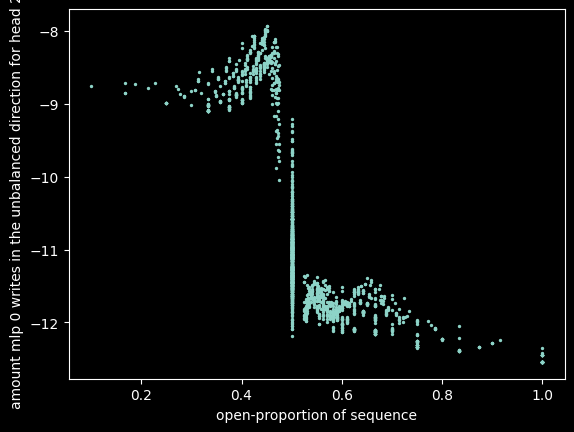

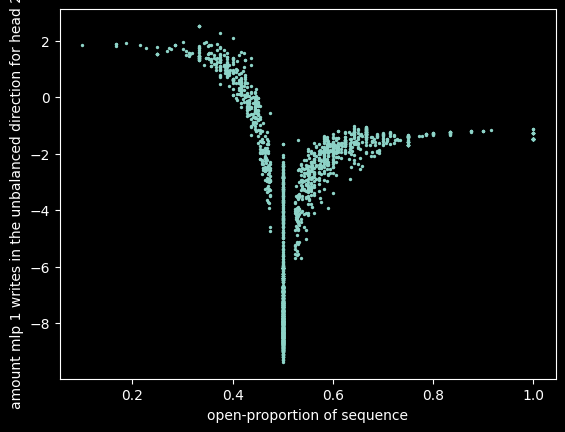

In [290]:
if MAIN:
    plt.scatter(data.open_proportion[data.starts_open], in_d_20[3, data.starts_open], s=2)
    plt.ylabel("amount mlp 0 writes in the unbalanced direction for head 2.0")
    plt.xlabel("open-proportion of sequence")
    plt.show()

if MAIN:
    plt.scatter(data.open_proportion[data.starts_open], in_d_20[6, data.starts_open], s=2)
    plt.ylabel("amount mlp 1 writes in the unbalanced direction for head 2.0")
    plt.xlabel("open-proportion of sequence")
    plt.show()

In [292]:
if MAIN:
    plt.scatter(data.open_proportion[data.starts_open], in_d_20[3, data.starts_open]+in_d_20[6, data.starts_open], s=2, )
    plt.ylabel("amount mlp 0/1 writes in the unbalanced direction for head 2.0")
    plt.xlabel("open-proportion of sequence"
    # show color bar
    # set the color limits
    plt.clim(0, 1)
    # set color map RdBu
    plt.set_cmap('RdBu')
    plt.colorbar()
    plt.show()

SyntaxError: '(' was never closed (180125153.py, line 4)

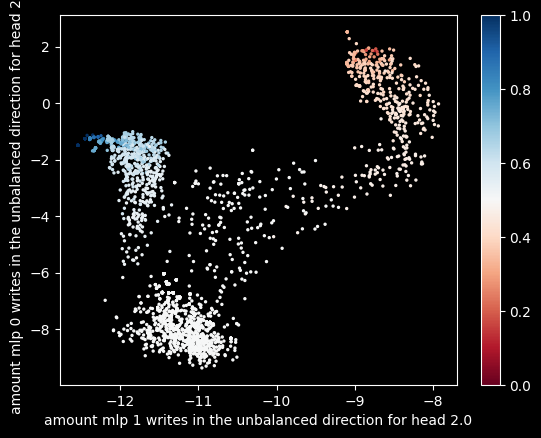

In [291]:
if MAIN:
    plt.scatter(in_d_20[3, data.starts_open], in_d_20[6, data.starts_open], s=2, c = data.open_proportion[data.starts_open])
    plt.ylabel("amount mlp 0 writes in the unbalanced direction for head 2.0")
    plt.xlabel("amount mlp 1 writes in the unbalanced direction for head 2.0")
    # show color bar
    # set the color limits
    plt.clim(0, 1)
    # set color map RdBu
    plt.set_cmap('RdBu')
    plt.colorbar()
    plt.show()

In [302]:
model.layers[1].linear2.weight.shape # weight has shape embed_size by embed_size

torch.Size([56, 56])

torch.Size([1, 5000, 42, 3136])

In [322]:
def out_by_neuron(model, data, layer):
    '''
    Return shape: [len(data), seq_len, neurons, out]
    '''
    f_B_x = get_outputs(model, data, model.layers[layer].activation)
    A = model.layers[layer].linear2.weight
    return einsum("sample seq neuron, out neuron -> sample seq neuron out", f_B_x, A)

@functools.cache
def out_by_neuron_in_20_dir(model, data, layer):
    out_by_neuron_activation = out_by_neuron(model, data, layer)
    pre_20_dir = get_pre_20_dir(model, data)
    return out_by_neuron_activation @ pre_20_dir
    
out_by_neuron_in_20_dir(model, data, 2).shape

r2: 0.993
pre_wOV_dir.shape: torch.Size([56])


torch.Size([5000, 42, 56])

In [327]:
def plot_neurons(model, data, failure_types, layer):
    # Get neuron significances for head 2.0, sequence position #1 output
    neurons_in_d = out_by_neuron_in_20_dir(model, data, layer)[data.starts_open, 1, :].detach()

    # Get data that can be turned into a dataframe (plotly express is sometimes easier to use with a dataframe)
    # Plot a scatter plot of all the neuron contributions, color-coded according to failure type, with slider to view neurons
    neuron_numbers = repeat(t.arange(model.d_model), "n -> (s n)", s=data.starts_open.sum())
    failure_types = repeat(failure_types[data.starts_open], "s -> (s n)", n=model.d_model)
    data_open_proportion = repeat(data.open_proportion[data.starts_open], "s -> (s n)", n=model.d_model)
    df = pd.DataFrame({
        "Output in 2.0 direction": neurons_in_d.flatten(),
        "Neuron number": neuron_numbers,
        "Open-proportion": data_open_proportion,
        "Failure type": failure_types
    })
    px.scatter(
        df, 
        x="Open-proportion", y="Output in 2.0 direction", color="Failure type", animation_frame="Neuron number",
        title=f"Neuron contributions from layer {layer}", 
        template="simple_white", height=500, width=800
    ).update_traces(marker_size=3).update_layout(xaxis_range=[0, 1], yaxis_range=[-5, 5]).show(renderer="browser")

    # Work out the importance (average difference in unbalanced contribution between balanced and inbalanced dirs) for each neuron
    # Plot a bar chart of the per-neuron importances
    neuron_importances = neurons_in_d[~data.isbal[data.starts_open]].mean(0) - neurons_in_d[data.isbal[data.starts_open]].mean(0)
    px.bar(
        x=t.arange(model.d_model), y=neuron_importances, 
        title=f"Importance of neurons in layer {layer}", 
        labels={"x": "Neuron number", "y": "Mean contribution in unbalanced dir"},
        template="simple_white", height=400, width=600, #hovermode="x unified"
    ).show(renderer="browser")

if MAIN:
    for layer in range(2):
        plot_neurons(model, data, failure_types, layer)

Neurons appear to calculate the open proportion/closed proportion of the brackets and can be composed to check if this number is 0.5. Some neurons only detect > 0.5 or less 0.5 proportions and some respond to both. 

# Undestanding how the open proportion is calculated

In [347]:
def get_Q_and_K(model: ParenTransformer, layer: int, head: int) -> Tuple[t.Tensor, t.Tensor]:
    '''
    Get the Q and K weight matrices for the attention head at the given indices.

    Return: Tuple of two tensors, both with shape (embedding_size, head_size)
    '''
    W_Q_weights = model.layers[layer].self_attn.W_Q.weight
    W_K_weights = model.layers[layer].self_attn.W_K.weight
    W_Q_weights = rearrange(W_Q_weights, '(nheads headsize) embed_size -> nheads embed_size headsize', nheads = model.nhead)
    W_K_weights = rearrange(W_K_weights, '(nheads headsize) embed_size -> nheads embed_size headsize', nheads = model.nhead)
    return W_Q_weights[head], W_K_weights[head]

def qk_calc_termwise(
    model: ParenTransformer, layer: int, head: int, q_embedding: t.Tensor, k_embedding: t.Tensor
) -> t.Tensor:
    '''
    Get the pre-softmax attention scores that would be calculated by the given attention head from the given embeddings.

    q_embedding: tensor of shape (seq_len, embedding_size)
    k_embedding: tensor of shape (seq_len, embedding_size)

    Returns: tensor of shape (seq_len, seq_len)
    '''
    W_Q, W_K = get_Q_and_K(model, layer, head)
    Q = q_embedding @ W_Q
    K = k_embedding @ W_K
    return Q @ K.T


if MAIN:
    w5d5_tests.qk_test(model, get_Q_and_K)
    w5d5_tests.test_qk_calc_termwise(model, tokenizer, qk_calc_termwise)

All tests in `qk_test` passed.
All tests in `test_qk_calc_termwise` passed.


In [364]:
i = tokenizer.t_to_i['(']
i

3

In [371]:
def embedding(model: ParenTransformer, tokenizer: SimpleTokenizer, char: str) -> torch.Tensor:
    assert char in ("(", ")")
    tokens = []
    i = tokenizer.t_to_i[char]
    return model.encoder(t.tensor(i).unsqueeze(0))

if MAIN:
    w5d5_tests.embedding_test(model, tokenizer, embedding)

All tests in `embedding_test` passed.


In [372]:
if MAIN:
    open_emb = embedding(model, tokenizer, "(")
    closed_emb = embedding(model, tokenizer, ")")
    pos_embeds = model.pos_encoder.pe
    open_emb_ln_per_seqpos = model.layers[0].norm1(open_emb.to(DEVICE) + pos_embeds[1:41])
    close_emb_ln_per_seqpos = model.layers[0].norm1(closed_emb.to(DEVICE) + pos_embeds[1:41])
    attn_score_open_avg = qk_calc_termwise(model, 0, 0, open_emb_ln_per_seqpos, 0.5 * (open_emb_ln_per_seqpos + close_emb_ln_per_seqpos))
    attn_prob_open = attn_score_open_avg.softmax(-1).detach().clone().numpy()
    px.imshow(
        attn_prob_open, 
        color_continuous_scale="RdBu_r", height=500, width=550,
        labels={"x": "Key Position", "y": "Query Position", "color": "Attn prob"},
        title="Predicted Attention Probabilities for '(' query", origin="lower"
    ).update_layout(margin=dict(l=60, r=60, t=80, b=40)).show()

Queries are 

In [408]:
data.strs[0]

'(()((())()(((())()))(('

In [400]:
data.toks[0]

tensor([0, 3, 3, 4, 3, 3, 3, 4, 4, 3, 4, 3, 3, 3, 3, 4, 4, 3, 4, 4, 4, 3, 3, 2,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [404]:
sum([i.startswith('(') for i in data.strs])

3604

In [405]:
sum([i.startswith(')') for i in data.strs])

1396

In [407]:
sum([i[0] = tokenizer.i for i in data.toks])

tensor([[0, 3, 3,  ..., 1, 1, 1],
        [0, 4, 4,  ..., 1, 1, 1],
        [0, 3, 3,  ..., 1, 1, 1],
        ...,
        [0, 3, 4,  ..., 1, 1, 1],
        [0, 3, 4,  ..., 1, 1, 1],
        [0, 4, 4,  ..., 1, 1, 1]])

In [415]:
sum([i[1]==3 for i in data_len_40.toks])

tensor(105)

In [414]:
def avg_attn_probs_0_0(
    model: ParenTransformer, data: DataSet, tokenizer: SimpleTokenizer, query_token: int
) -> t.Tensor:
    '''
    Calculate the average attention probs for the 0.0 attention head for the provided data when the query is the given query token.
    Returns a tensor of shape (seq, seq)
    '''
    layer = 0
    head = 0
    x = get_inputs(model, data, model.layers[layer].self_attn.W_Q)
    print(query_token)
    x_begins_with_bracket = x[[i[1] == query_token for i in data.toks]]
    print(x_begins_with_bracket.shape)
    attention_pattern = model.layers[layer].self_attn.attention_pattern_pre_softmax(x_begins_with_bracket)
    return attention_pattern.softmax(-1).mean(0)[head]

if MAIN:
    data_len_40 = DataSet.with_length(data_tuples, 40)
    for paren in ("(", ")"):
        tok = tokenizer.t_to_i[paren]
        attn_probs_mean = avg_attn_probs_0_0(model, data_len_40, tokenizer, tok).detach().clone()
        px.imshow(
            attn_probs_mean,
            color_continuous_scale="RdBu", range_color=[0, 0.23], height=500, width=550,
            labels={"x": "Key Position", "y": "Query Position", "color": "Attn prob"},
            title=f"Attention patterns with query = {paren}", origin="lower"
        ).update_layout(margin=dict(l=60, r=60, t=80, b=40)).show()

3
torch.Size([105, 42, 56])


4
torch.Size([67, 42, 56])


In [420]:
if MAIN:
    tok = tokenizer.t_to_i["("]
    attn_probs_mean = avg_attn_probs_0_0(model, data, tokenizer, tok).detach().clone()
    px.bar(
        attn_probs_mean[1], title=f"Attention pattern for first query position, query token = {paren!r}",
        labels={"index": "Sequence position", "value": "Average attention"}, template="simple_white", height=500, width=600
    ).update_layout(showlegend=False, margin_l=100, yaxis_range=[0, 0.1], hovermode="x unified").show()

3
torch.Size([3604, 42, 56])


In [422]:
if MAIN:
    tok = tokenizer.t_to_i["("]
    attn_probs_mean = avg_attn_probs_0_0(model, data_len_40, tokenizer, tok).detach().clone()
    px.bar(
        attn_probs_mean[1], title=f"Attention pattern for first query position, query token = {paren!r}",
        labels={"index": "Sequence position", "value": "Average attention"}, template="simple_white", height=500, width=600
    ).update_layout(showlegend=False, margin_l=100, yaxis_range=[0, 0.1], hovermode="x unified").show()

3
torch.Size([105, 42, 56])


# Testing the hypothesis

Exercise - show that W_{OV} L(\color{red}``)"\color{black})W 
OV
​
 L(‘‘)") and W_{OV} L(\color{red}``("\color{black})W 
OV
​
 L(‘‘(") are pointed away from each other and are of similar magnitudes, demonstrating that this head is "tallying" the open and close parens that come after it.

In [424]:
model.layers[0].norm1

LayerNorm((56,), eps=1e-05, elementwise_affine=True)

In [447]:
W_O = model.layers[0].self_attn.W_O.weight#.shape
W_V = model.layers[0].self_attn.W_V.weight
W_OV = W_O @ W_V.T
W_OV.shape

torch.Size([56, 56])

In [500]:
def embedding_OV_0_0(model, emb_in: t.Tensor) -> t.Tensor:
    layer = 0 
    head = 0
    WOV = get_WO(model, layer, head) @ get_WV(model, layer, head)
    return emb_in @ WOV


if MAIN:
    lr, r2 = get_ln_fit(model, data, model.layers[0].norm1, seq_pos = None)
    L = t.tensor(lr.coef_) 
    print(f'r2 = {r2:.3f}')
    
    emb_in_left_bracket = model.encoder(
        t.tensor(tokenizer.t_to_i["("]).to(DEVICE).unsqueeze(0).unsqueeze(0)
        ).detach()

    emb_in_right_bracket = model.encoder(
        t.tensor(tokenizer.t_to_i[")"]).to(DEVICE).unsqueeze(0).unsqueeze(0)
        ).detach()

    WOV_left = embedding_OV_0_0(model, emb_in_left_bracket @ L ).detach().unsqueeze(0)
    WOV_right = embedding_OV_0_0(model, emb_in_right_bracket @ L ).detach().unsqueeze(0)

    print(t.cosine_similarity(
        WOV_left, WOV_right, dim=-1
    )[0][0].item())


    print(t.norm(WOV_left))
    print(t.norm(WOV_right))

r2 = 0.994
-0.974112331867218
tensor(1158.4965)
tensor(2272.1667)


# Finding a Misclassifier sequence

In [553]:
predictions = run_model_on_data(model, data)
predicted_balance = predictions[:,0] < 0.001
indices = np.where((predicted_balance!=data.isbal).tolist())[0].tolist()
indices

[152,
 221,
 316,
 464,
 758,
 788,
 1501,
 1782,
 1798,
 2473,
 2793,
 3096,
 3305,
 3834,
 4088,
 4692,
 4974]

In [556]:
for i in indices:
    print(data.strs[i])



(()()()(())(()())())()((((()()()(())))))
()(()()()(()(()()(()))))(()(()()))
()(()()()()())()(()(()()()((()()))))
(()(()))(()((((())))((((()))()()))))()
(((()(()))((())()(())((())))()())()())
()(()(()))((()()())()())(((()())))(())
()(()()(())()((()(()))))()()()
((())()()())(())()(()(()))(()()()())
(((()()())(())((()))))()()(())
()((((())((()()))(()()()))))(())
(((()))((()(()()(())()))())((()))())()
(()((()))((())))()()()(()(()()()(()())))
(((((((())))())(()))))()((())(()))()()
((((()()((((()())(()))))(())()()))))()
()(())()(((((()())(())(())()(())))()()))
((()()))()()(())(((((()(())()(()))))))
(((()))(((())()()())())())(())()()()()


In [560]:
import random
for i in range(10):
    x = random.choice(range(len(data)))
    print(data.strs[x])

)())))((()(()()))))()()((()))()(
)()(())((())
()()())(
()(((())))
(((()()(()(()()())))(())))()
(())())()()()())(())(())())(()
)())
))()()))()((()))
(())()
((())((())((()))()))


In [543]:
#

[array([ 152,  221,  316,  464,  758,  788, 1501, 1782, 1798, 2473, 2793,
        3096, 3305, 3834, 4088, 4692, 4974])]

In [588]:
if MAIN:
    print("Update the examples list below below find adversarial examples")
    examples = [
        "((()()))()()(())(((((()(())()(()))))))()(((()()))()()(())(((((()(())()(())))))))",
        "(())", 
        "))(("]
    m = max(len(ex) for ex in examples)
    toks = tokenizer.tokenize(examples).to(DEVICE)
    out = model(toks)
    truth_vector = [is_balanced_forloop_vectorized(ex) for ex in examples]
    print("\n".join([f"{ex:{m}} -> {p:.4%} balanced confidence, {truth}" for (ex, p, truth) in zip(examples, out.exp()[:, 1], truth_vector)]))

Update the examples list below below find adversarial examples
((()()))()()(())(((((()(())()(()))))))()(((()()))()()(())(((((()(())()(()))))))) -> 0.0007% balanced confidence, True
(())                                                                             -> 99.9989% balanced confidence, True
))((                                                                             -> 0.0005% balanced confidence, False
